<a href="https://colab.research.google.com/github/arshiabagchi/Lane-Detection/blob/main/Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install opencv-python opencv-python-headless

In [ ]:
from google.colab import files

# Upload lane videos (curved_lane.mp4, straight_lane.mp4, or any)
uploaded = files.upload()

Saving straight_lane.mp4 to straight_lane.mp4
Saving curved_lane.mp4 to curved_lane.mp4


In [ ]:
# Colab-compatible Lane Detection
import cv2
import numpy as np
import math, copy
from google.colab.patches import cv2_imshow

# ---------------- CURVED LANE FUNCTIONS ----------------
def preprocessing_curved(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)   # fixed (used img, not undefined frame)
    gblur = cv2.GaussianBlur(gray,(5,5),0)
    white_mask = cv2.threshold(gblur,200,255,cv2.THRESH_BINARY)[1]
    lower_yellow = np.array([0,100,100])
    upper_yellow = np.array([210,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return mask

def regionOfInterest(img, polygon):
    mask = np.zeros_like(img, dtype=np.uint8)
    x1,y1=polygon[0]; x2,y2=polygon[1]; x3,y3=polygon[2]; x4,y4=polygon[3]
    m1=(y2-y1)/(x2-x1); m2=(y3-y2)/(x3-x2); m3=(y4-y3)/(x4-x3); m4=(y4-y1)/(x4-x1)
    b1=y1-m1*x1; b2=y2-m2*x2; b3=y3-m3*x3; b4=y4-m4*x4
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if i>=m1*j+b1 and i>=m2*j+b2 and i>=m3*j+b3 and i<=m4*j+b4:
                mask[i][j]=1
    return np.multiply(mask,img)

def warp(img, src, dst, size):
    matrix=cv2.getPerspectiveTransform(src,dst)
    return cv2.warpPerspective(img,matrix,size)

def unwarp(img, src, dst, size):
    matrix=cv2.getPerspectiveTransform(dst,src)
    return cv2.warpPerspective(img,matrix,size)

def fitCurve(img):
    histogram=np.sum(img[img.shape[0]//2:,:],axis=0)
    midpoint=histogram.shape[0]//2
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    nwindows,margin,minpix=50,100,50
    window_height=img.shape[0]//nwindows
    y,x=img.nonzero()
    leftx_current,rightx_current=leftx_base,rightx_base
    left_idx,right_idx=[],[]
    for window in range(nwindows):
        win_y_low=img.shape[0]-(window+1)*window_height
        win_y_high=img.shape[0]-window*window_height
        win_xleft_low,leftx_high=leftx_current-margin,leftx_current+margin
        win_xright_low,rightx_high=rightx_current-margin,rightx_current+margin
        good_left=((y>=win_y_low)&(y<win_y_high)&(x>=win_xleft_low)&(x<leftx_high)).nonzero()[0]
        good_right=((y>=win_y_low)&(y<win_y_high)&(x>=win_xright_low)&(x<rightx_high)).nonzero()[0]
        left_idx.append(good_left); right_idx.append(good_right)
        if len(good_left)>minpix: leftx_current=int(np.mean(x[good_left]))
        if len(good_right)>minpix: rightx_current=int(np.mean(x[good_right]))
    left_idx=np.concatenate(left_idx); right_idx=np.concatenate(right_idx)
    leftx,rightx=x[left_idx],x[right_idx]; lefty,righty=y[left_idx],y[right_idx]
    left_fit=np.polyfit(lefty,leftx,2); right_fit=np.polyfit(righty,rightx,2)
    return left_fit,right_fit

def findPoints(shape,left_fit,right_fit):
    ploty=np.linspace(0,shape[0]-1,shape[0])
    left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    pts_left=np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    return pts_left,pts_right

def fillCurves(shape,pts_left,pts_right):
    pts=np.hstack((pts_left,pts_right))
    img=np.zeros((shape[0],shape[1],3),dtype='uint8')
    cv2.fillPoly(img,np.int_([pts]),(0,0,255))
    return img

def oneToThreeChannel(binary):
    img=np.zeros((binary.shape[0],binary.shape[1],3),dtype='uint8')
    img[:,:,0]=binary; img[:,:,1]=binary; img[:,:,2]=binary
    return img

def drawCurves(img,pts_left,pts_right):
    img=oneToThreeChannel(img)
    cv2.polylines(img,np.int32([pts_left]),False,(0,0,255),10)
    cv2.polylines(img,np.int32([pts_right]),False,(0,255,255),10)
    return img

def radiusOfCurvature(img,left_fit,right_fit):
    y_eval=img.shape[0]/2
    left=((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5)/(2*left_fit[0])
    right=((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5)/(2*right_fit[0])
    return round(left,2),round(right,2),round((left+right)/2,2)

# ---------------- STRAIGHT LANE FUNCTIONS ----------------
def preprocessing_straight(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gblur=cv2.GaussianBlur(gray,(5,5),0)
    return cv2.threshold(gblur,150,255,cv2.THRESH_BINARY)[1]

def slopeIntercept(line):
    m=(line[1][1]-line[0][1])/(line[1][0]-line[0][0])
    b=line[1][1]-m*line[1][0]; return m,b

def removeCloseLines(linelist,m):
    linelist_copy=copy.deepcopy(linelist)
    for line in linelist:
        m1,_=slopeIntercept(line)
        if abs(m-m1)<=0.5:
            if line in linelist_copy: linelist_copy.remove(line)
    return linelist_copy

def lineDetection(img,masked_img,solid_prev,dashed_prev):
    img_copy=copy.deepcopy(img); h,w=masked_img.shape
    linesP=cv2.HoughLinesP(masked_img,1,np.pi/180,50,None,30,20)
    if linesP is None: return img_copy,solid_prev,dashed_prev
    linelist=[tuple((line[0][:2],line[0][2:])) for line in linesP.tolist()]
    lengths=[math.dist(l[0],l[1]) for l in linelist]
    try: solid=linelist[lengths.index(max(lengths))]; linelist.remove(solid)
    except: solid=solid_prev
    m,b=slopeIntercept(solid); linelist=removeCloseLines(linelist,m)
    initial=(int((h*0.6-b)/m),int(h*0.6)); final=(int((h-b)/m),h)
    img_copy=cv2.line(img_copy,initial,final,(0,255,0),5)
    lengths=[math.dist(l[0],l[1]) for l in linelist]
    try: dashed=linelist[lengths.index(max(lengths))]
    except: dashed=dashed_prev
    if dashed is not None:
        m,b=slopeIntercept(dashed)
        initial=(int((h*0.6-b)/m),int(h*0.6)); final=(int((h-b)/m),h)
        img_copy=cv2.line(img_copy,initial,final,(0,0,255),5)
    return img_copy,solid,dashed

# ---------------- MAIN EXECUTION ----------------
def run_curved(input_path,output_path,show_every=50):
    cap=cv2.VideoCapture(input_path)
    fourcc=cv2.VideoWriter_fourcc(*'XVID')
    out=cv2.VideoWriter(output_path,fourcc,25,(1280,720))
    frame_count=0
    while True:
        ret,frame=cap.read()
        if not ret: break
        processed=preprocessing_curved(frame)
        h,w=processed.shape
        polygon=[(int(w*0.15),int(h*0.94)),(int(w*0.45),int(h*0.62)),(int(w*0.58),int(h*0.62)),(int(0.95*w),int(0.94*h))]
        masked=regionOfInterest(processed,polygon)
        src=np.float32([[int(w*0.49),int(h*0.62)],[int(w*0.58),int(h*0.62)],[int(w*0.15),int(h*0.94)],[int(0.95*w),int(0.94*h)]])
        dst=np.float32([[0,0],[400,0],[0,960],[400,960]])
        warped=warp(masked,src,dst,(400,960))
        kernel=np.ones((11,11),np.uint8); opening=cv2.morphologyEx(warped,cv2.MORPH_CLOSE,kernel)
        left,right=fitCurve(opening); pts_left,pts_right=findPoints((960,400),left,right)
        fill=fillCurves((960,400),pts_left,pts_right)
        unwarped=unwarp(fill,src,dst,(w,h))
        combo=cv2.addWeighted(frame,1,unwarped,1,0)
        out.write(combo)
        frame_count+=1
        if frame_count%show_every==0: cv2_imshow(combo)
    cap.release(); out.release(); print("Curved lane saved:",output_path)

def run_straight(input_path,output_path,show_every=50):
    cap=cv2.VideoCapture(input_path)
    fourcc=cv2.VideoWriter_fourcc(*'XVID')
    out=cv2.VideoWriter(output_path,fourcc,25,(960,540))
    solid_prev,dashed_prev=None,None; count=0
    while True:
        ret,frame=cap.read()
        if not ret: break
        processed=preprocessing_straight(frame); h,w=processed.shape
        polygon=[(int(w*0.1),h),(int(w*0.45),int(h*0.6)),(int(w*0.55),int(h*0.6)),(int(0.95*w),h)]
        masked=regionOfInterest(processed,polygon)
        detected,solid_prev,dashed_prev=lineDetection(frame,masked,solid_prev,dashed_prev)
        out.write(detected); count+=1
        if count%show_every==0: cv2_imshow(detected)
    cap.release(); out.release(); print("Straight lane saved:",output_path)



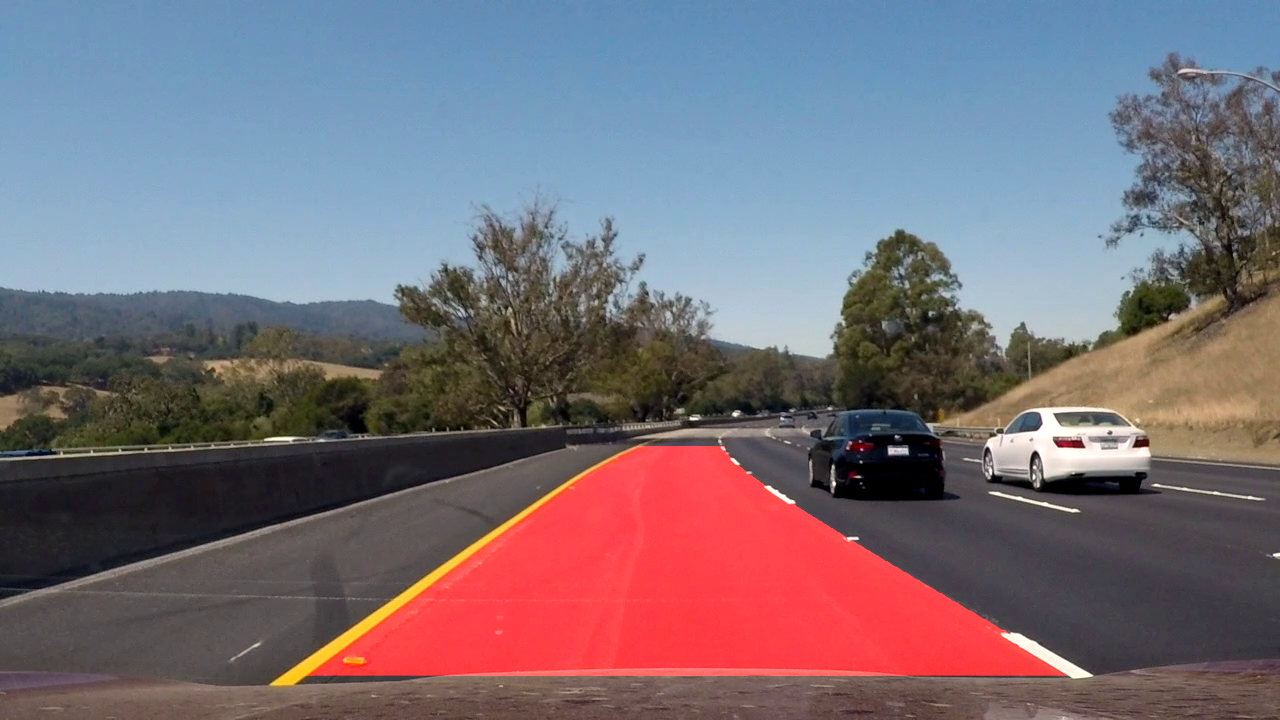

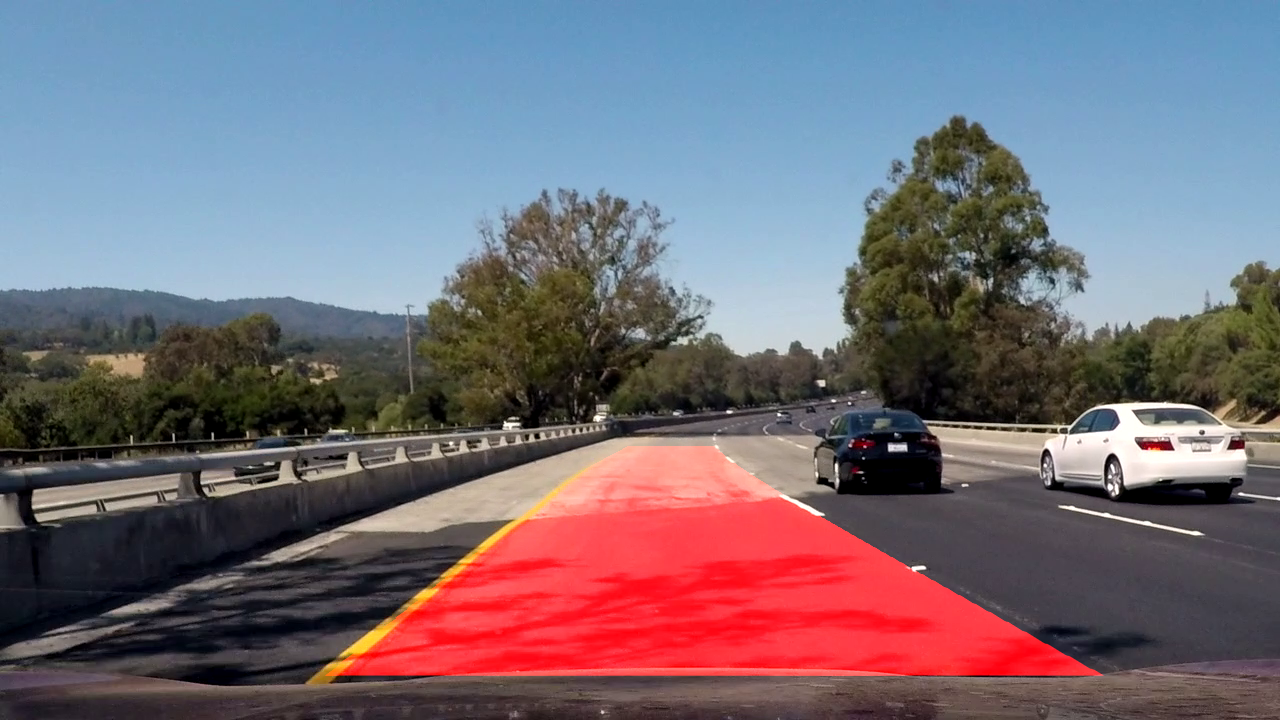

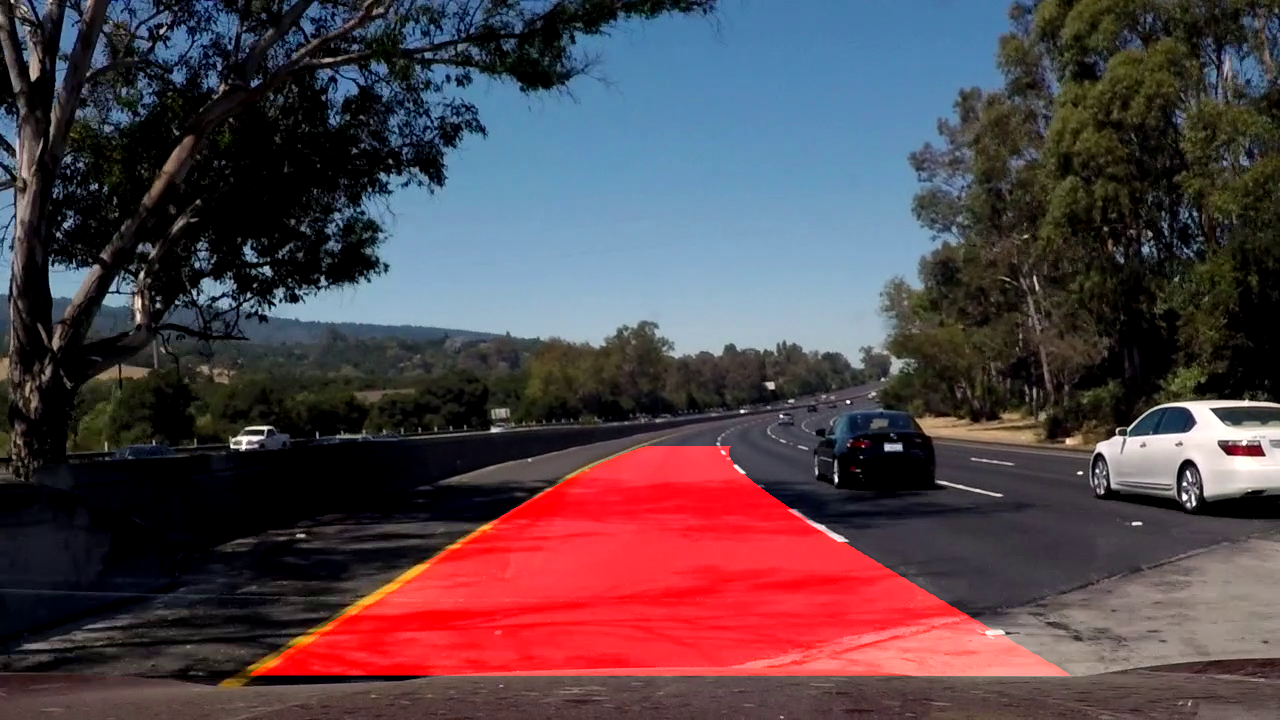

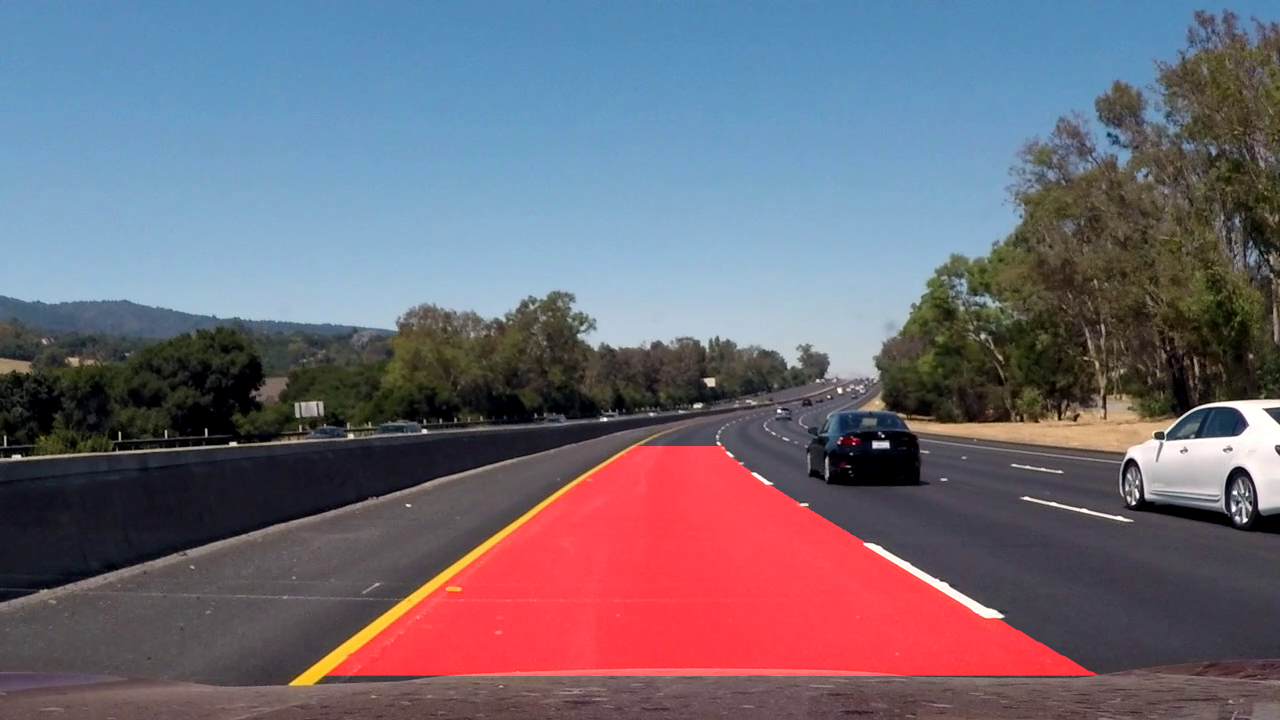

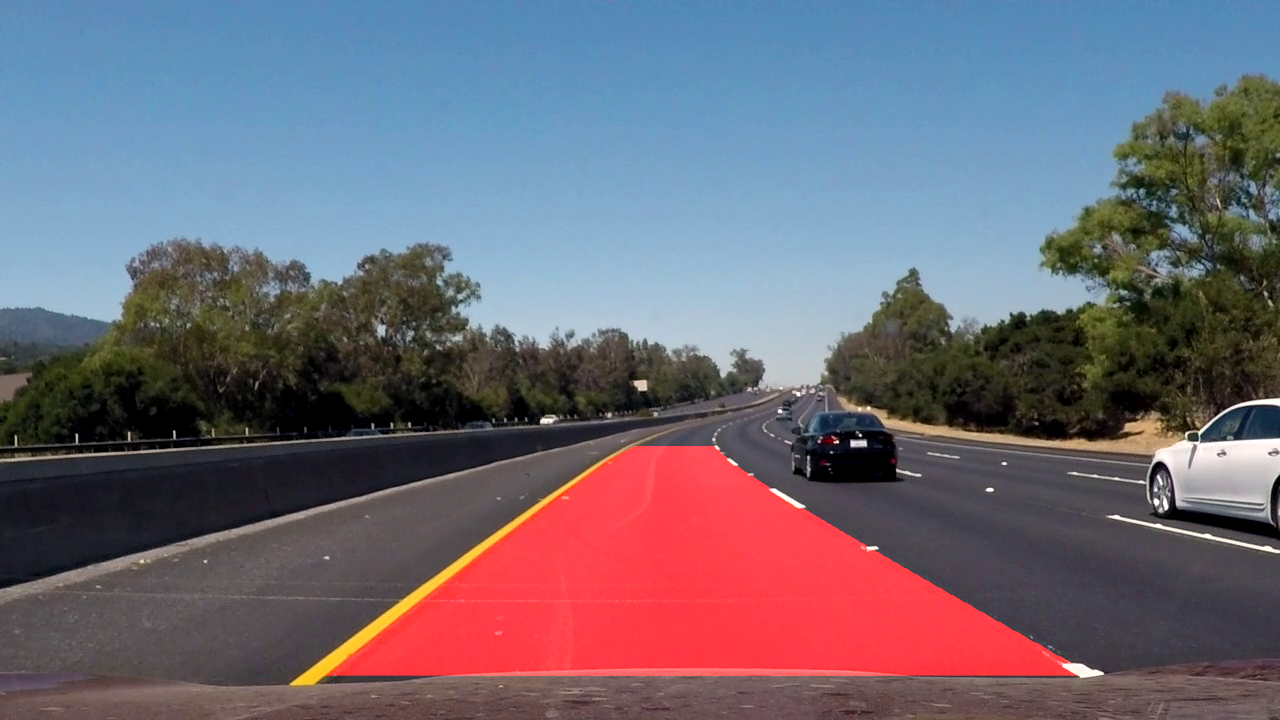

Curved lane saved: /content/curved_output.avi


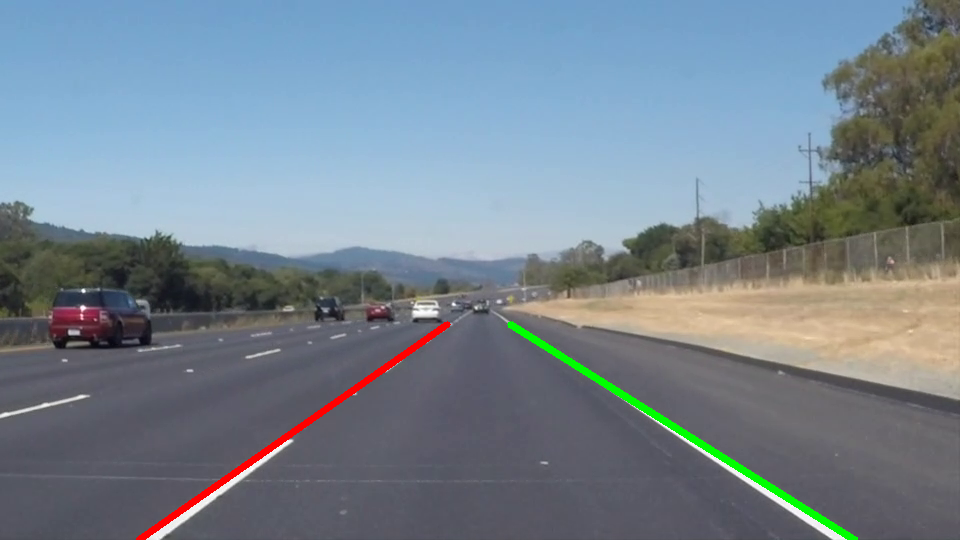

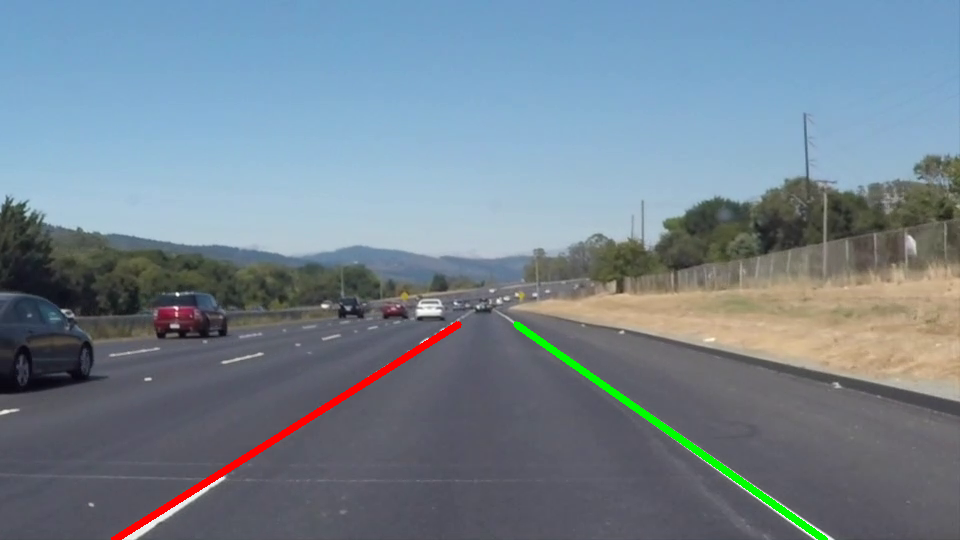

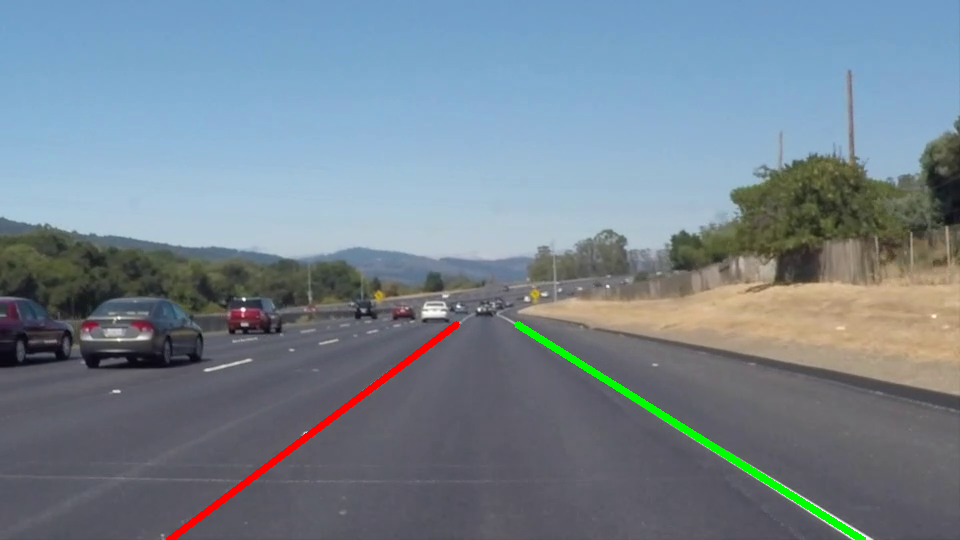

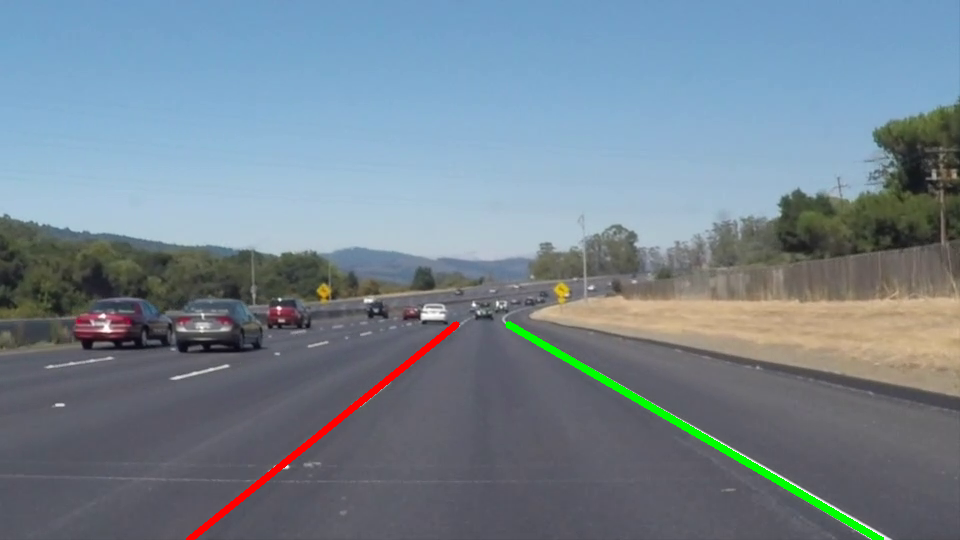

Straight lane saved: /content/straight_output.avi


In [ ]:
# ---------------- RUN BOTH ----------------
run_curved("/content/curved_lane.mp4","/content/curved_output.avi")
run_straight("/content/straight_lane.mp4","/content/straight_output.avi")
